# Import modules

In [1]:
#-----------------------------------------------------------
# IMPORT ALL NECESSARY MODULES
#-----------------------------------------------------------
import os

import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
# from IPython.display import display, Image
# from PIL import Image
# from tqdm import tqdm
# from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

2023-08-03 04:53:48.696682: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-03 04:53:48.726890: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 04:53:49.691536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset Analytics

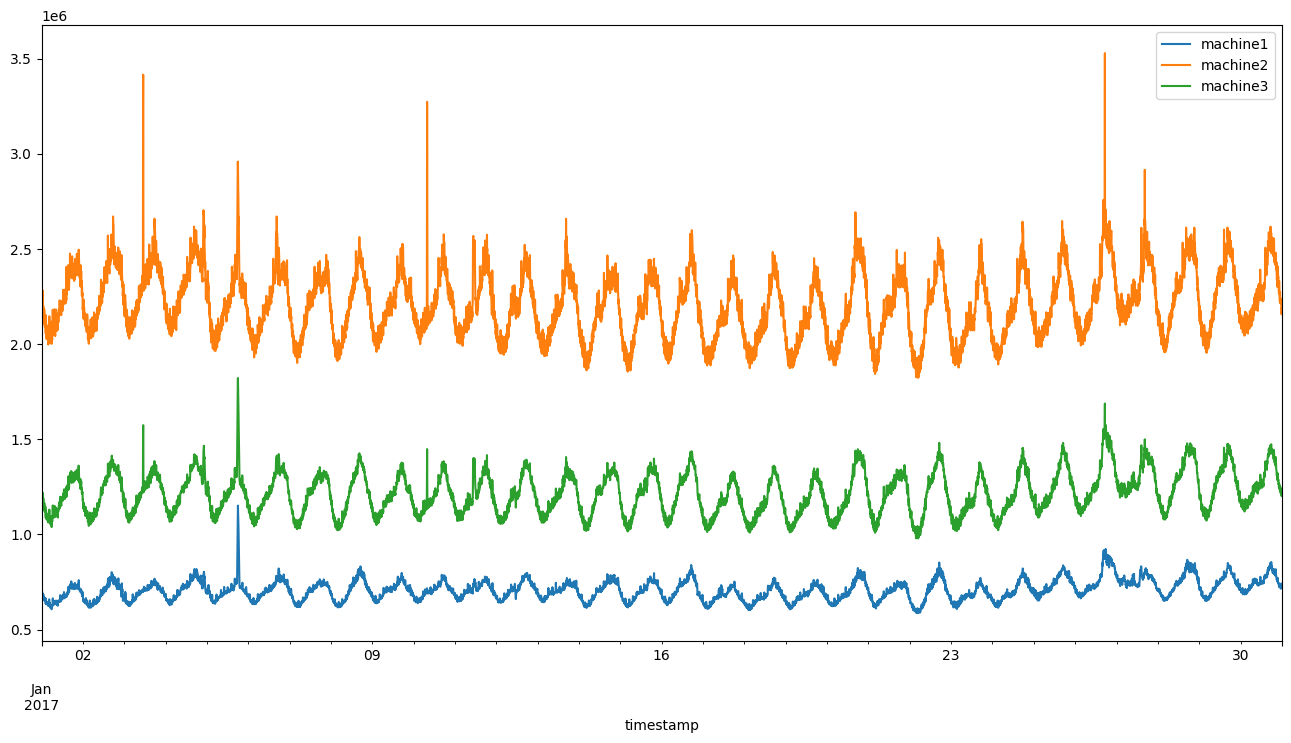

In [2]:
#-----------------------------------------------------------
# LOAD THE DATASET AND PLOT THE OBSERVATIONS
#-----------------------------------------------------------

df = pd.read_csv('/Volumes/Share/tran_s2/zhehehehehehe/Predicting-cloud-CPU-usage/azure.csv')
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()
df.plot(figsize=(16, 8))
plt.show()

# Clean Data

In [3]:
#-----------------------------------------------------------
# CREATE TRAIN-TEST SPLIT (80:20)
#-----------------------------------------------------------
TRAIN_LENGTH = round(len(df)*0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH : ]

In [4]:
#-----------------------------------------------------------
# SCALING VALUES
#-----------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)

# Set up the data

In [5]:
#-----------------------------------------------------------
# GENERATOR TO DATA TO FEED INTO MODEL
#-----------------------------------------------------------
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - n_lags -1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [6]:
#-----------------------------------------------------------
# DEFINING INPUTS AND EXPECTED OBSERVATIONS
#-----------------------------------------------------------
TIME_STEPS = 500
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

# Set up Model


In [7]:
#-----------------------------------------------------------
# USING A LSTM MODEL FOR PREDICTION ON TIME SERIES
#-----------------------------------------------------------
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(tf.keras.layers.LSTM(512,return_sequences=False))
model.add(tf.keras.layers.Dense(3))
model.summary()

2023-08-03 04:53:52.208021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-03 04:53:52.228999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-03 04:53:52.229148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500, 512)          1056768   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                                 
Total params: 3157507 (12.04 MB)
Trainable params: 3157507 (12.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [9]:
#-----------------------------------------------------------
# DEFINING CALLBACKS
#-----------------------------------------------------------
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

checkpoint_path = "/Volumes/Share/tran_s2/zhehehehehehe/Predicting-cloud-CPU-usage-on-Azure-data-master/model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=999999)

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Train

In [11]:
callbacks = [es , lr_red, cp_callback]
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_split=0.25,
                    batch_size=128,
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)

#-----------------------------------------------------------
# I TRAINED MY MODEL ON BATCHSIZES - 64,128,256
#-----------------------------------------------------------

Epoch 1/10


2023-08-03 04:53:54.971508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-03 04:53:55.083750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-03 04:53:55.126608: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9298157ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-03 04:53:55.126623: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-08-03 04:53:55.129628: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/38 [..............................] - ETA: 1:21 - loss: 0.2533

2023-08-03 04:53:55.206908: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 [==============================] - 6s 104ms/step - loss: 0.0829 - val_loss: 0.0240 - lr: 0.0010
Epoch 2/10
38/38 [==============================] - 4s 95ms/step - loss: 0.0262 - val_loss: 0.0216 - lr: 0.0010
Epoch 3/10
38/38 [==============================] - 4s 95ms/step - loss: 0.0225 - val_loss: 0.0215 - lr: 0.0010
Epoch 4/10
38/38 [==============================] - 4s 96ms/step - loss: 0.0216 - val_loss: 0.0230 - lr: 0.0010
Epoch 5/10
38/38 [==============================] - 4s 96ms/step - loss: 0.0215 - val_loss: 0.0226 - lr: 0.0010
Epoch 6/10
38/38 [==============================] - 4s 96ms/step - loss: 0.0216 - val_loss: 0.0225 - lr: 0.0010
Epoch 7/10
38/38 [==============================] - 4s 96ms/step - loss: 0.0223 - val_loss: 0.0201 - lr: 0.0010
Epoch 8/10
38/38 [==============================] - 4s 96ms/step - loss: 0.0213 - val_loss: 0.0200 - lr: 0.0010
Epoch 9/10
38/38 [==============================] - 4s 96ms/step - loss: 0.0208 - val_loss: 0.0199 - lr: 0.0010
Ep

In [12]:
# model.save_weights("/Volumes/Share/tran_s2/zhehehehehehe/Predicting-cloud-CPU-usage-on-Azure-data-master/model/cp.ckpt")
# model.save('/Volumes/Share/tran_s2/zhehehehehehe/Predicting-cloud-CPU-usage-on-Azure-data-master/model/model.keras')

# Eval

In [13]:
# model = tf.create_model()
# model = model.load_weights('./checkpoints/my_checkpoint')
# model = tf.keras.models.load_model('/Volumes/Share/tran_s2/zhehehehehehe/Predicting-cloud-CPU-usage/model/model.keras')

39/39 [==============================] - 1s 21ms/step


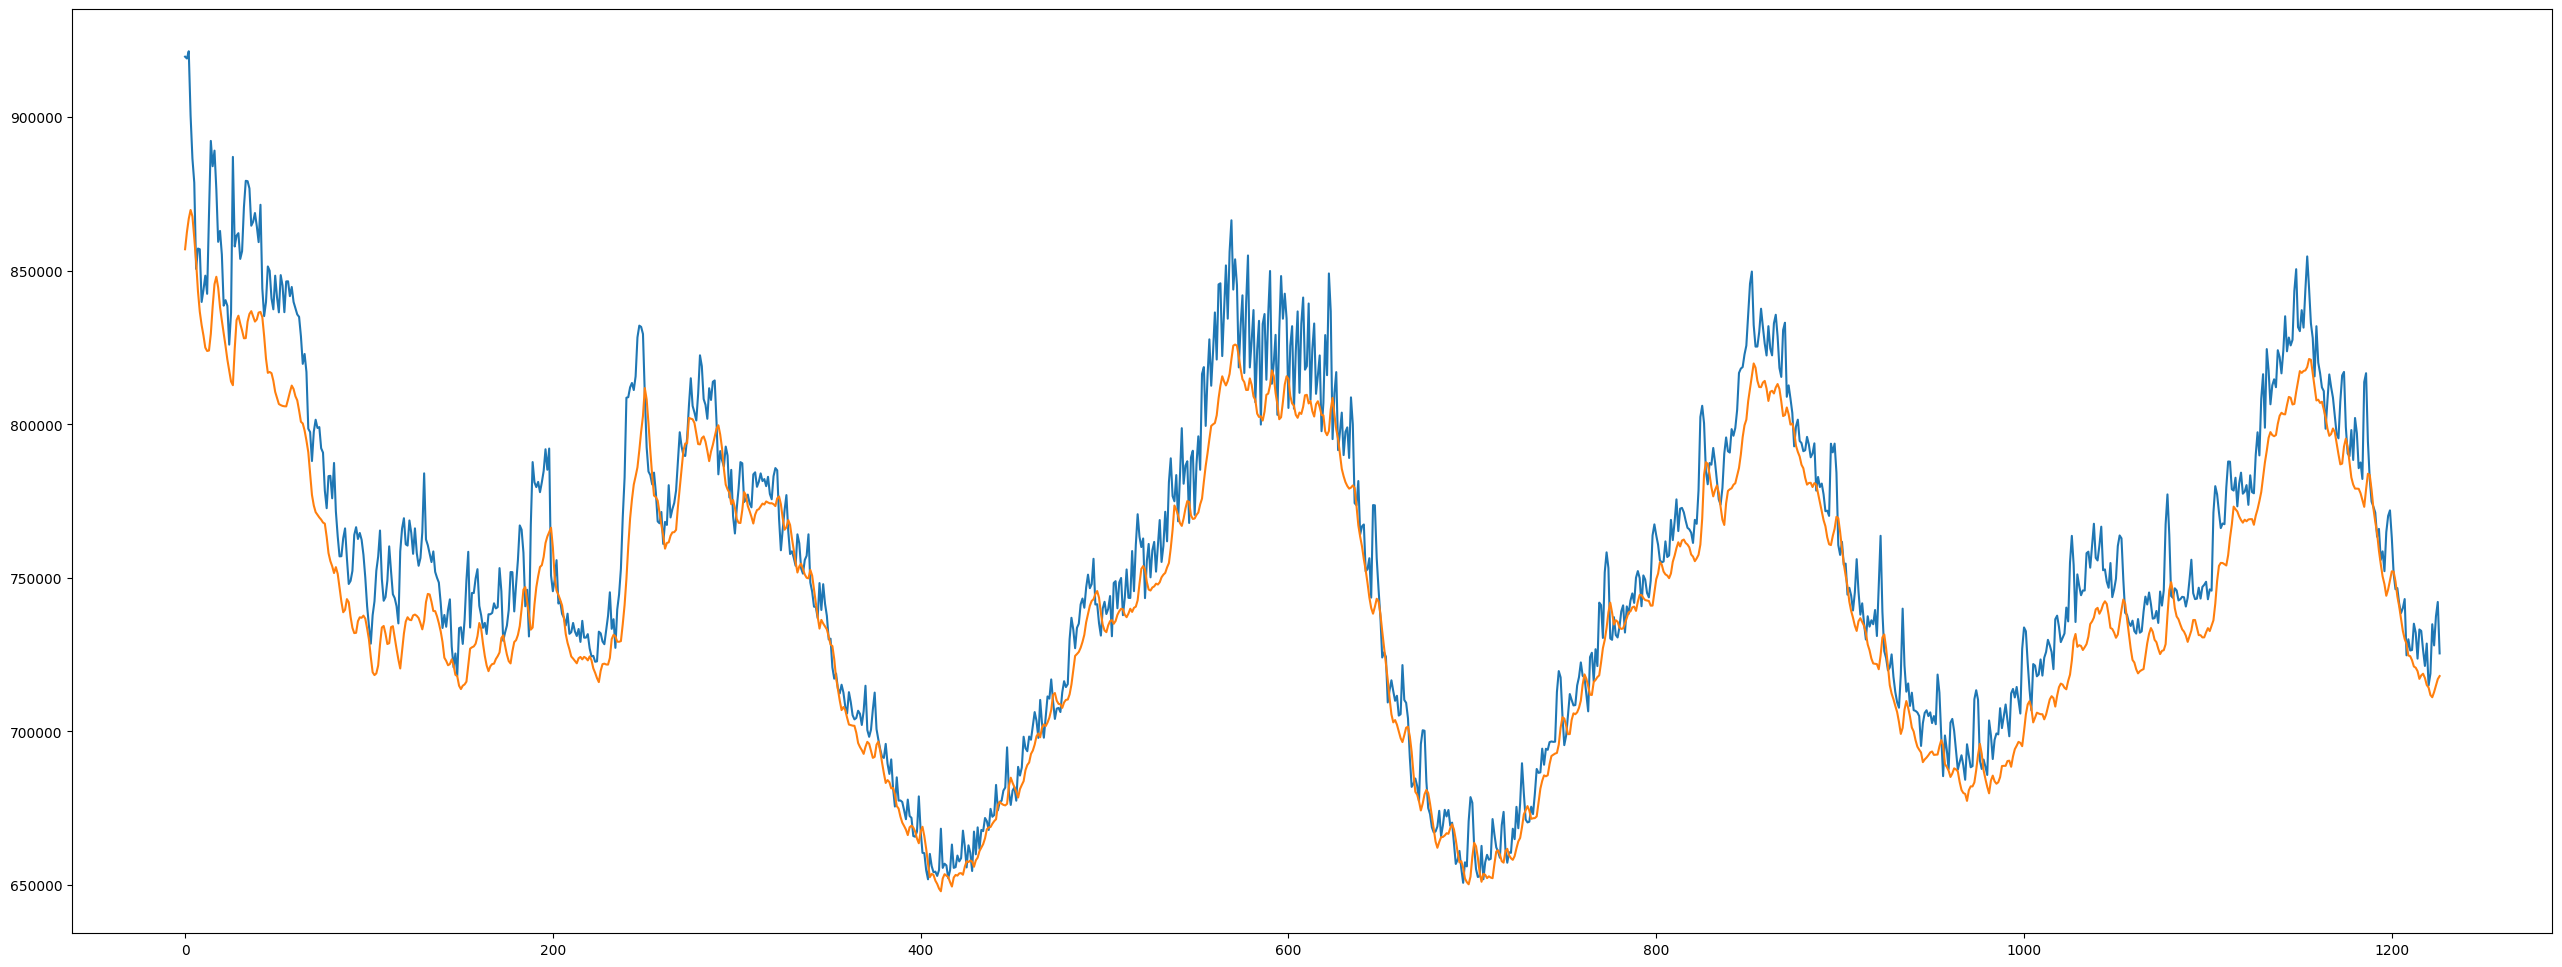

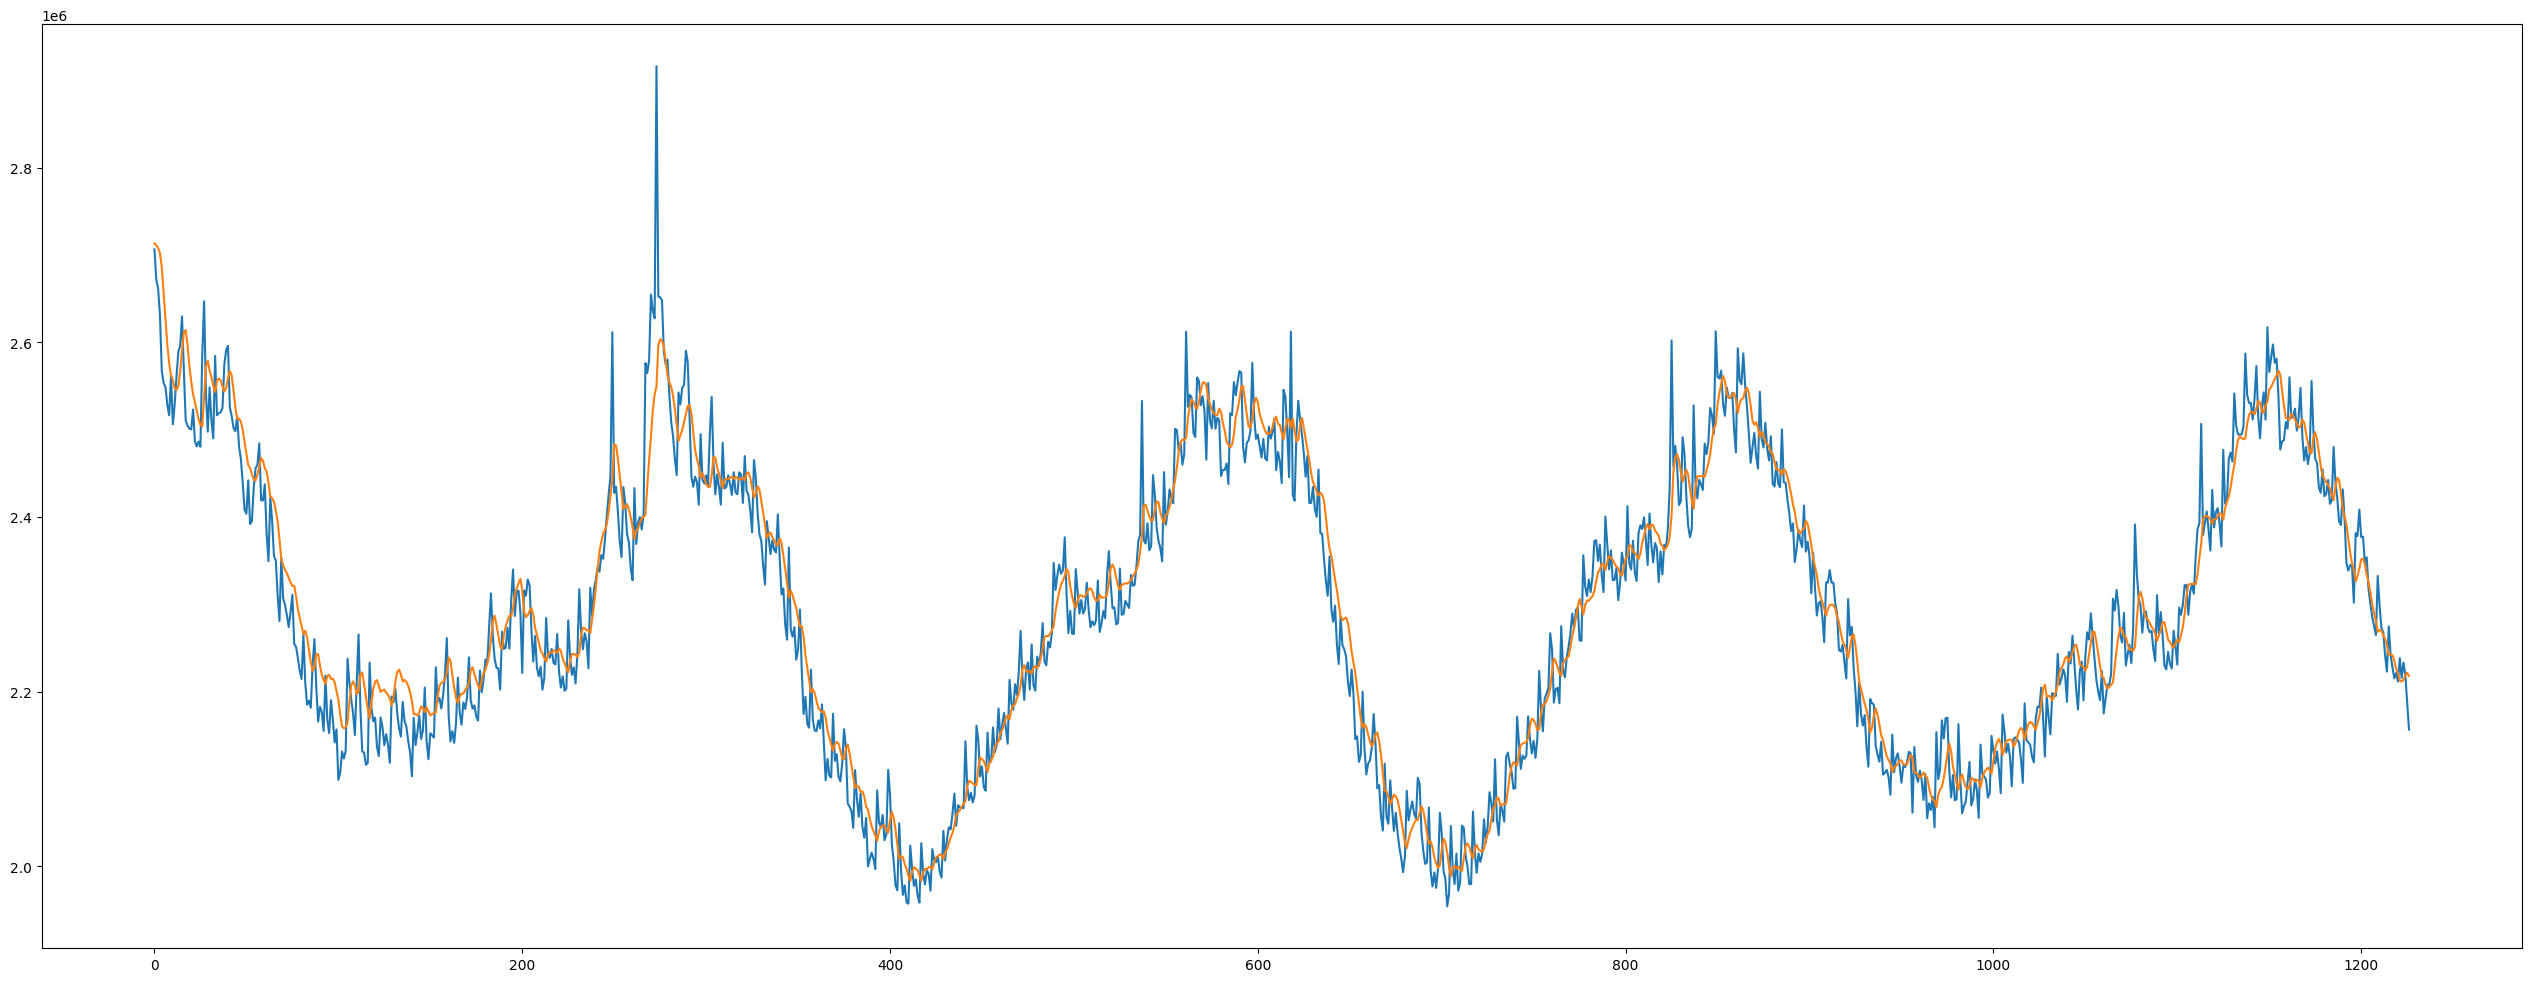

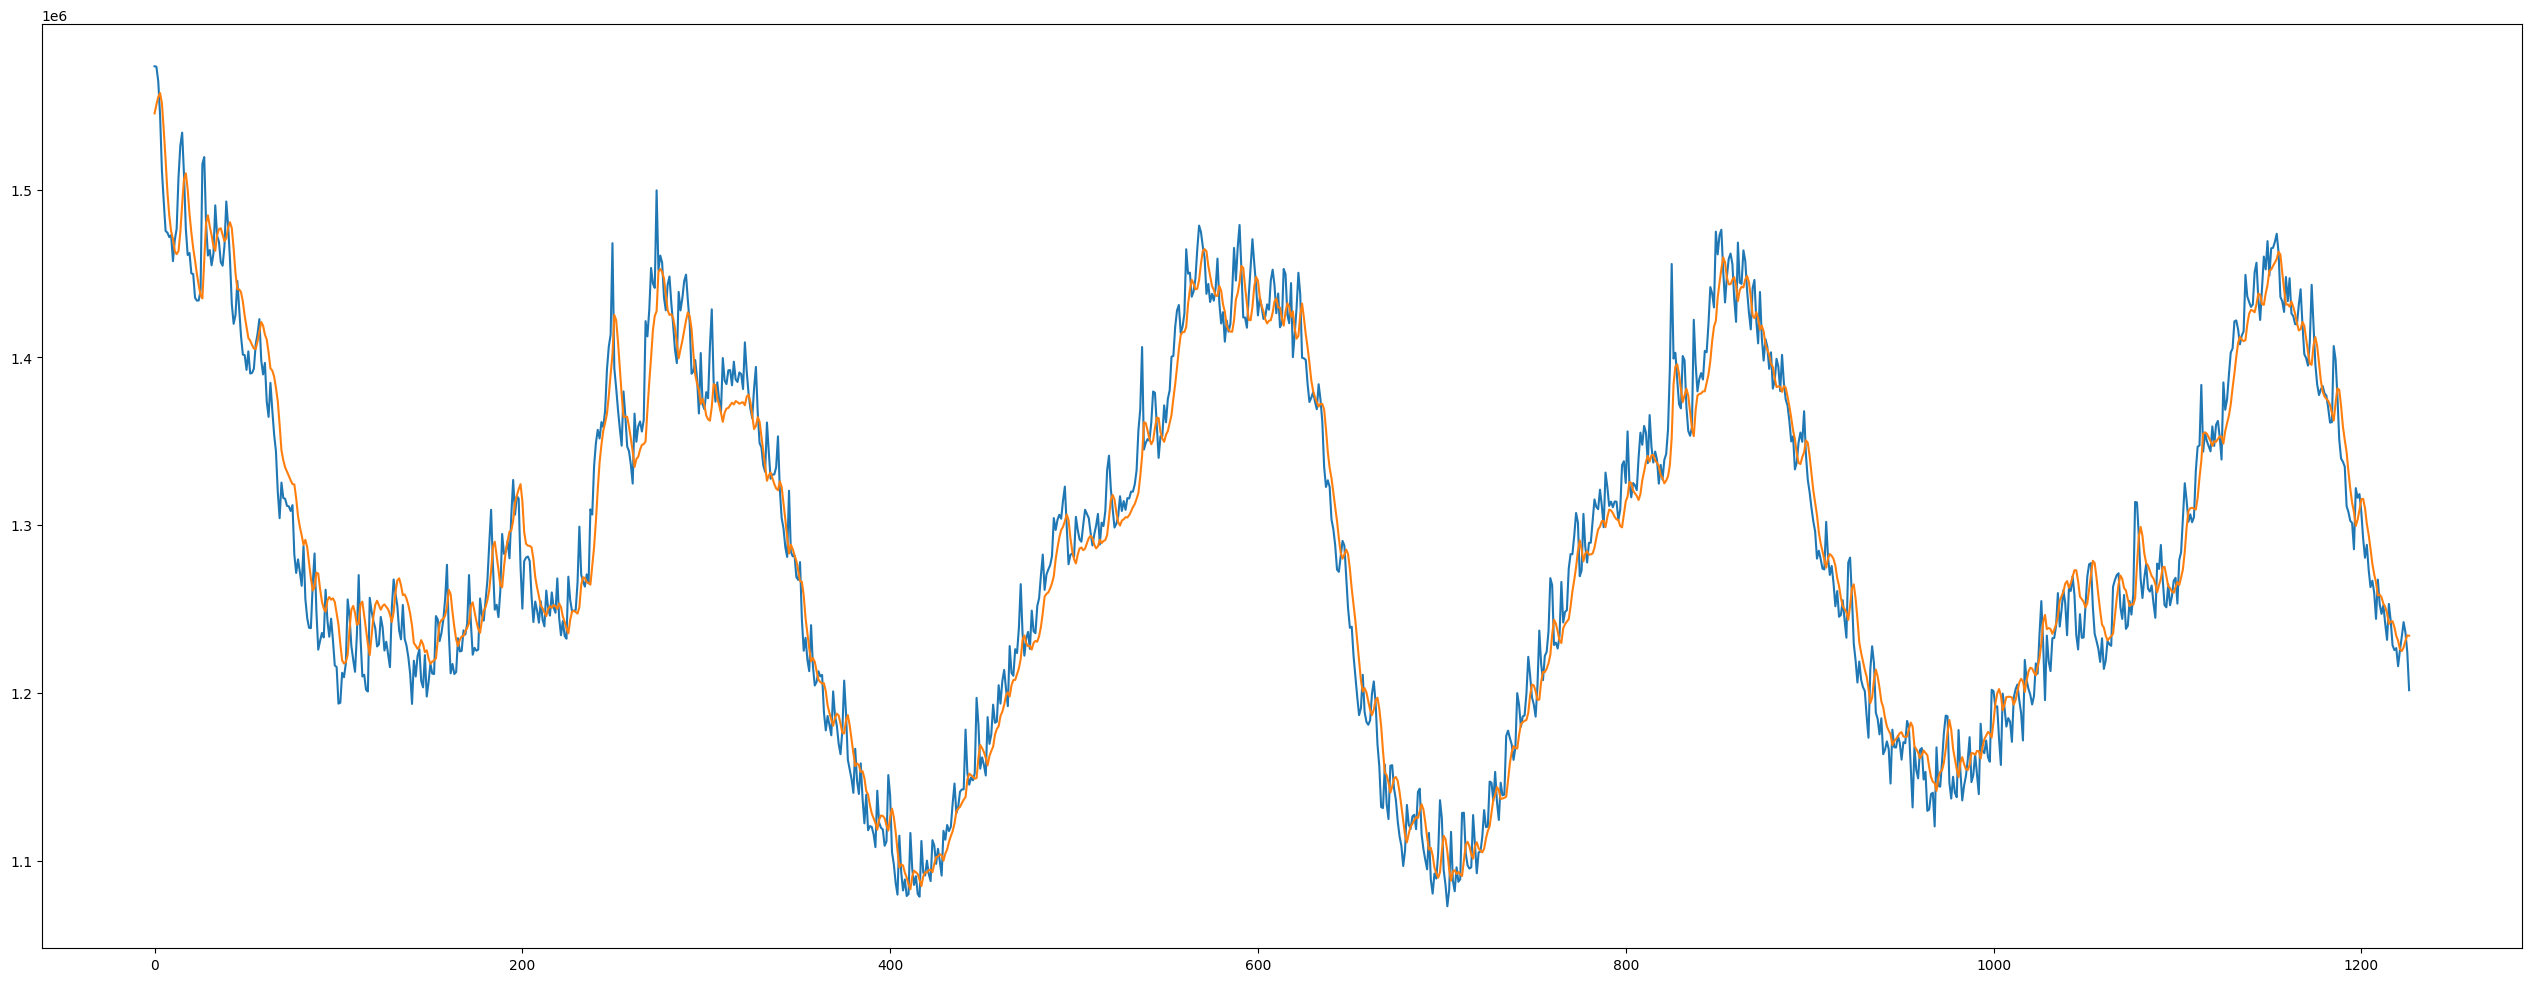

In [14]:
#-----------------------------------------------------------
# MAKING PREDICTIONS ON TEST DATA AND PLOTTING PREDICTED AND
# OBSERVED VALUES
#-----------------------------------------------------------
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY= pd.DataFrame(y_test,columns=['machine1','machine2','machine3'])
PredY=pd.DataFrame(preds,columns=['machine1','machine2','machine3'])


plot_max = plt.figure(1)
plt.plot(TestY['machine1'])
plt.plot(PredY['machine1'])
plt.show()

plot_min = plt.figure(2)
plt.plot(TestY['machine2'])
plt.plot(PredY['machine2'])
plt.show()

plot_avg = plt.figure(3)
plt.plot(TestY['machine3'])
plt.plot(PredY['machine3'])
plt.show()

In [15]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 28643.12 RMSE
Test Score: 143.884520 MAE
Test Score: 1.475682 MAPE
